# Geospatial data

### Getting geospatial data from open sources

Querying points of interest (POIs) using Overpass API. Overpass API is OSM’s querying API. It is incredibly powerful in that it can very quickly return queried features, and allows for selection of location, tags, proximity, and more.

Let’s query for restaurants near the University of Toronto.

In [ ]:
# !pip install overpass

In [1]:
import overpass

api = overpass.API()

# We're looking for restaurants within 1000m of a given point
overpass_query = """
(node["amenity"="restaurant"](around:1000,43.66, -79.39);
 way["amenity"="restaurant"](around:1000,43.66, -79.39);
 rel["amenity"="restaurant"](around:1000,43.66, -79.39);
);
out center;
"""

restaurants = api.get(overpass_query)

The example above uses the overpass package, which by default returns results in geojson format. See the <a href="https://github.com/mvexel/overpass-api-python-wrapper", target="new">overpass documentation</a> for more information.


Next, let’s extract some data about each restaurant, and then plot all of them on a map. This time, we’ll use a plotly ScatterMapBox, which uses tiles from MapBox. You can refer to plotly’s documentation here. Each POI on that map has a tooltip that shows the restaurant’s name when hovered.

In [2]:
import plotly.graph_objects as obj

# Extract the lon, lat and name of each restaurant:
coords = []
text = []
for elem in restaurants['features']:
    latlon = elem['geometry']['coordinates']
    if latlon == []: continue
    coords.append(latlon)
    if 'name'  not in elem['properties']:
        text.append('NONAME')
    else:
        text.append(elem['properties']['name'])
        
# Convert into a dictionary for plotly
restaurant_dict = dict(type='scattermapbox',
                   lat=[x[1] for x in coords], 
                   lon=[x[0] for x in coords],
                   mode='markers',
                   text=text,
                   marker=dict(size=8, color='blue'),
                   hoverinfo='text',    
                   showlegend=False)


# plotting restaurants' locations around University of Toronto

center=(43.662643, -79.395689) # UofT main building

fig = obj.Figure(obj.Scattermapbox(restaurant_dict))

# defining plot layout
fig.update_layout(mapbox_style="stamen-terrain")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, mapbox = {'center': {'lat': center[0], 'lon': center[1]}, 'zoom': 13})
fig.show()

You can compile your own dataset using the Overpass QL language that runs on Overpass turbo. You can use this query language to mine OpenStreetMaps data, filter it, and get it ready to be used by osmnx or any library that parses .osm files. Below is a quick review about using Overpass API, which is the official API for reading data from OpenStreetMap servers. All the online routing services and software use it. Additionally, we will usually use Nominatim to do geocoding/geo-decoding; translating addresses to/from (latitude-longitude).

Also be aware of the fact that most of the time if you are building a dataset over a very big area in the map, the graph parsed from the data by osmnx won’t be complete, even though there are physically feasible routes that could make the graph complete and connect all the nodes. This deficiency is usually because of the incomplete relations and data of osm.

### Getting data using OverPass QL
Fire up Overpass turbo and run these scripts and export it as .osm files.

Finding the bounding box around an area of interest is a recurring problem in writing OverPass QL queries. To solve for that, we can use bbox finder. Don’t forget to change the coordinate format to latitude/longitude at the right corner after drawing the polygon around the area of interest.

### Getting data using Overpass turbo’s Wizard

<a href="https://overpass-turbo.eu/">Overpass turbo</a>’s Wizard provides an easy way to auto-generate Overpass QL queries. Wizard syntax is similar to that of a search engine. An example of Wizard syntax is amenity=hospital that generates an Overpass QL query to find all the hospitals in a certain region of interest. Hospital locations will be visualized on the map and can be downloaded/copied using the “Export” button. The data can be exported as GeoJSON, GPX, KML, raw OSM data, or raw data directly from Overpass API. You can then use osmnx to read .osm files with osmnx.graph_from_xml.

### Calculating haversine distance between two points of interest

In [3]:
# coordinates of two points in (latitude, longitude) format
LA = (34.052235, -118.243683) # Los Angeles, USA 
Madrid = (40.416775, -3.703790) # Madrid, Spain

#### Calculating haversine distance using math

In [4]:
from math import radians, sin, cos, sqrt, atan2

# convert coordinates to radians
lat1, lon1 = radians(LA[0]), radians(LA[1])
lat2, lon2 = radians(Madrid[0]), radians(Madrid[1])

# calculate haversine distance
a = sin((lat2 - lat1) / 2) ** 2 + cos(lat1) * cos(lat2) * sin((lon2 - lon1) / 2) ** 2
c = 2 * atan2(sqrt(a), sqrt(1 - a))
distance = 6371 * c  # 6371 is the radius of the Earth in kilometers

print(distance)

9362.645008370095


#### Calculating haversine distance using haversine library

In [5]:
# !pip install haversine
from haversine import haversine

# calculate the distance in kilometers
distance = haversine(LA, Madrid)
print(distance)

9362.657940606176


#### Calculating haversine distance using geopy

In [ ]:
# !pip install geopy

In [6]:
from geopy.distance import geodesic

print(geodesic(LA,Madrid).km)

9383.664590383833


In [7]:
from geopy.distance import geodesic
from geopy.geocoders import Nominatim

def haversine_distance(city1, city2):
    # Coordinates of the two cities (latitude, longitude)
    coords_city1 = city1.latitude, city1.longitude
    coords_city2 = city2.latitude, city2.longitude
    
    # Calculate the Haversine distance
    distance = geodesic(coords_city1, coords_city2).kilometers
    return distance

# Initialize the geocoder
geolocator = Nominatim(user_agent="city_distance_app")

# Get the coordinates of the cities
city1 = geolocator.geocode("Los Angeles")
city2 = geolocator.geocode("Madrid")

# Calculate the Haversine distance
distance = haversine_distance(city1, city2)
print(f"Haversine Distance between {city1.address} and {city2.address}: {distance:.2f} kilometers")

Haversine Distance between Los Angeles, Los Angeles County, California, United States and Madrid, Comunidad de Madrid, España: 9383.51 kilometers


#### Calculating haversine distance using sklearn

In [ ]:
# !pip install sklearn

In [8]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians

# convert coordinates to radians
LA_in_radians = [radians(_) for _ in LA]
Madrid_in_radians = [radians(_) for _ in Madrid]

distance = haversine_distances([LA_in_radians, Madrid_in_radians])
distance=distance* 6371000/1000  # multiply by Earth radius to get kilometers

print(distance)

c:\Users\Alaa\.conda\envs\ox\lib\site-packages\scipy\__init__.py:155: UserWarning:

A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2



[[   0.         9362.64500837]
 [9362.64500837    0.        ]]


### Handling data using geopandas

In [9]:
import geopandas as gpd

# file downloaded from https://data.ontario.ca/dataset/ontario-s-health-region-geographic-data
ontario = gpd.read_file(r"data/OntarioHealth/Ontario_Health_Regions.shp")
ontario = ontario.to_crs('EPSG:4326')
ontario = ontario[(ontario.REGION != "North")] # exclude Northern Ontario

ontario

Shape_Leng    Shape_Area   REGION REGION_ID  \
0  4.845977e+06  1.089122e+11     East        04   
2  4.860262e+06  7.543033e+10     West        01   
3  2.755817e+06  3.189867e+10  Central        02   
4  2.196396e+05  3.715020e+08  Toronto        03   

                                            geometry  
0  MULTIPOLYGON (((-77.54191 43.89913, -77.54234 ...  
2  MULTIPOLYGON (((-82.68871 41.68453, -82.68631 ...  
3  MULTIPOLYGON (((-79.70667 43.39271, -79.70805 ...  
4  MULTIPOLYGON (((-79.40671 43.74414, -79.40648 ...

### Getting elevation Data

In [10]:
# Let’s first get the centroids for each region:
ontario['centroid'] = ontario.centroid
ontario

C:\Users\Alaa\AppData\Local\Temp\ipykernel_10412\136050928.py:2: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




Shape_Leng    Shape_Area   REGION REGION_ID  \
0  4.845977e+06  1.089122e+11     East        04   
2  4.860262e+06  7.543033e+10     West        01   
3  2.755817e+06  3.189867e+10  Central        02   
4  2.196396e+05  3.715020e+08  Toronto        03   

                                            geometry  \
0  MULTIPOLYGON (((-77.54191 43.89913, -77.54234 ...   
2  MULTIPOLYGON (((-82.68871 41.68453, -82.68631 ...   
3  MULTIPOLYGON (((-79.70667 43.39271, -79.70805 ...   
4  MULTIPOLYGON (((-79.40671 43.74414, -79.40648 ...   

                     centroid  
0  POINT (-77.18411 44.89013)  
2  POINT (-81.07741 43.36065)  
3  POINT (-79.65677 44.45330)  
4  POINT (-79.40531 43.67619)

Notice that calculating the centroid raises a warning. That’s because we are using EPSG:4326, which uses degrees as a unit of measure. This makes polygon calculations inaccurate, especially at larger scales. We will ignore this warning for this example, but keep in mind that centroids will not be accurate in this projection. For better results, you can calculate the centroids of a projection that uses a flat projection (that retains area) and then reproject it back to EPSG:4326.

For web use, when the desired effect is a visual centroid, it is possible to continue using a Mercator projection like EPSG:4326, while applications that require a “true” centroid should use a projection like Equal Area Cylindrical, which avoids distortion at the poles. See here for more details.

In [11]:
# Now, let’s query the Open Elevation API for the elevation (in metres) at the centroids for each region.
from requests import get

def get_elevation(centroid):
    query = (f'https://api.open-elevation.com/api/v1/lookup?locations={centroid.y},{centroid.x}')

    # Set a timeout on the request in case of a slow response
    r = get(query,timeout=30)

    # Only use the response if the status is successful
    if r.status_code!=200 and r.status_code!=201: return None

    elevation = r.json()['results'][0]['elevation']
    return elevation

elevations = []

for index, row in ontario.iterrows():
    elevations.append(get_elevation(row['centroid']))
    
ontario['elevations'] = elevations
ontario

Shape_Leng    Shape_Area   REGION REGION_ID  \
0  4.845977e+06  1.089122e+11     East        04   
2  4.860262e+06  7.543033e+10     West        01   
3  2.755817e+06  3.189867e+10  Central        02   
4  2.196396e+05  3.715020e+08  Toronto        03   

                                            geometry  \
0  MULTIPOLYGON (((-77.54191 43.89913, -77.54234 ...   
2  MULTIPOLYGON (((-82.68871 41.68453, -82.68631 ...   
3  MULTIPOLYGON (((-79.70667 43.39271, -79.70805 ...   
4  MULTIPOLYGON (((-79.40671 43.74414, -79.40648 ...   

                     centroid  elevations  
0  POINT (-77.18411 44.89013)       274.0  
2  POINT (-81.07741 43.36065)       353.0  
3  POINT (-79.65677 44.45330)       261.0  
4  POINT (-79.40531 43.67619)       125.0

In [ ]:
# !pip install folium

In [12]:
# let's visualzie this data
import folium

# Set starting location, initial zoom, and base layer source.
m = folium.Map(location=[43.67621,-79.40530],zoom_start=7, tiles='cartodbpositron', scrollWheelZoom=False, dragging=True)

for index, row in ontario.iterrows():
    # Simplify each region's polygon as intricate details are unnecessary
    sim_geo = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, name=row['REGION'],style_function=lambda x: {'fillColor': 'black'})
    folium.Popup(row['REGION']).add_to(geo_j)
    geo_j.add_to(m)

for index, row in ontario.iterrows():
    folium.Marker(location=[row['centroid'].y,row['centroid'].x], popup='Elevation: {}'.format(row['elevations'])).add_to(m)
m

### Fetching OpenStreetMap data using osmnx

In [ ]:
# !conda create -n ox -c conda-forge --strict-channel-priority osmnx

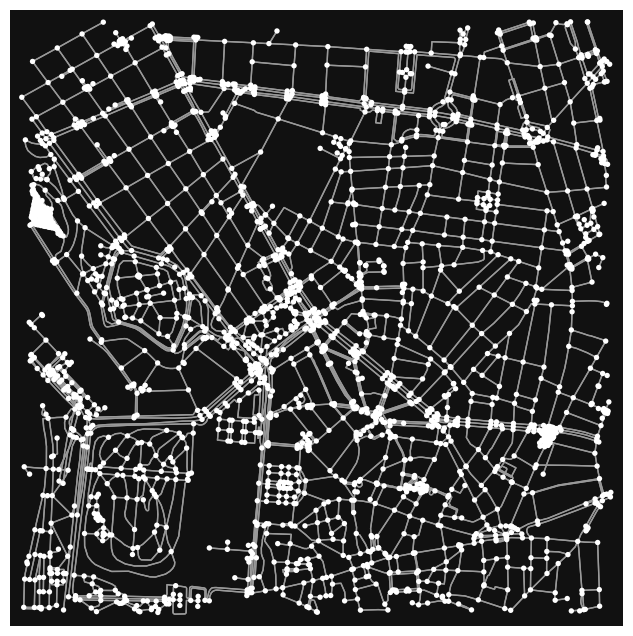

In [13]:
import osmnx as ox
import matplotlib.pyplot as plt


place_name = "Plaza de España, Madrid"

# fetch OSM street network (drive, walk, private, etc.) from the location
graph = ox.graph_from_address(place_name, network_type='walk')
fig, ax = ox.plot_graph(graph)

#### Edges and Node

We can extract the nodes and edges of the graph as separate structures.

In [14]:
nodes, edges = ox.graph_to_gdfs(graph)

nodes.head(5)

y         x  street_count highway                   geometry
osmid                                                                         
20953196  40.423230 -3.722300             3     NaN  POINT (-3.72230 40.42323)
20953221  40.422748 -3.721706             3     NaN  POINT (-3.72171 40.42275)
20953223  40.423529 -3.721877             3     NaN  POINT (-3.72188 40.42353)
20953226  40.420314 -3.706068             5     NaN  POINT (-3.70607 40.42031)
21723244  40.420394 -3.720117             3     NaN  POINT (-3.72012 40.42039)

In [15]:
edges.head(5)

osmid  oneway lanes  \
u        v          key                             
20953196 1339844565 0       4049532   False     1   
         1339844864 0      44618907   False   NaN   
         20953223   0    1184792209   False   NaN   
20953221 1339844565 0       4049532   False     1   
         849583483  0       7642940   False     1   

                                                name      highway maxspeed  \
u        v          key                                                      
20953196 1339844565 0                Calle de Mozart  residential       50   
         1339844864 0                Calle de Mozart  residential       30   
         20953223   0                Calle de Mozart  residential       30   
20953221 1339844565 0                Calle de Mozart  residential       50   
         849583483  0    Calle del Maestro Sorozábal  residential       50   

                        reversed  length  \
u        v          key                    
20953196 1339844565 0      False  15.977   
         1339844864 0       True   9.226   
         20953223   0       True  48.879   
20953221 1339844565 0       True  57.500   
         849583483  0       True  69.058   

                                                                  geometry  \
u        v          key                                                      
20953196 1339844565 0    LINESTRING (-3.72230 40.42323, -3.72217 40.42312)   
         1339844864 0    LINESTRING (-3.72230 40.42323, -3.72237 40.42329)   
         20953223   0    LINESTRING (-3.72230 40.42323, -3.72194 40.423...   
20953221 1339844565 0    LINESTRING (-3.72171 40.42275, -3.72217 40.42312)   
         849583483  0    LINESTRING (-3.72171 40.42275, -3.72229 40.42231)   

                        access junction tunnel service width bridge  
u        v          key                                              
20953196 1339844565 0      NaN      NaN    NaN     NaN   NaN    NaN  
         1339844864 0      NaN      NaN    NaN     NaN   NaN    NaN  
         20953223   0      NaN      NaN    NaN     NaN   NaN    NaN  
20953221 1339844565 0      NaN      NaN    NaN     NaN   NaN    NaN  
         849583483  0      NaN      NaN    NaN     NaN   NaN    NaN

We can further drill down to examine each individual node or edge.

In [16]:
# Rendering the 2nd node
list(graph.nodes(data=True))[1]

(20953221, {'y': 40.4227481, 'x': -3.7217065, 'street_count': 3})

In [17]:
# Rendering the 1st edge
list(graph.edges(data=True))[0]

(20953196,
 1339844565,
 {'osmid': 4049532,
  'oneway': False,
  'lanes': '1',
  'name': 'Calle de Mozart',
  'highway': 'residential',
  'maxspeed': '50',
  'reversed': False,
  'length': 15.977})

#### Street Types
Street types can also be retrieved for the graph:

In [18]:
print(edges['highway'].value_counts())

footway                                      3232
residential                                  1586
pedestrian                                    664
primary                                       374
tertiary                                      286
service                                       278
living_street                                 274
[footway, steps]                              200
steps                                         108
secondary                                     108
path                                           38
[footway, pedestrian]                          30
secondary_link                                 14
track                                          12
[residential, living_street]                   10
[living_street, residential]                   10
[footway, steps, pedestrian]                    8
[steps, pedestrian]                             8
[pedestrian, living_street]                     6
[pedestrian, residential]                       4


#### Calculating Network Statistics

In [19]:
ox.basic_stats(graph)

{'n': 2414,
 'm': 7280,
 'k_avg': 6.031483015741508,
 'edge_length_total': 292572.44599999924,
 'edge_length_avg': 40.188522802197696,
 'streets_per_node_avg': 3.0824357912178955,
 'streets_per_node_counts': {0: 0, 1: 284, 2: 0, 3: 1412, 4: 673, 5: 41, 6: 4},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.11764705882352941,
  2: 0.0,
  3: 0.5849212924606463,
  4: 0.2787903893951947,
  5: 0.016984258492129246,
  6: 0.0016570008285004142},
 'intersection_count': 2130,
 'street_length_total': 146286.22300000017,
 'street_segment_count': 3640,
 'street_length_avg': 40.18852280219785,
 'circuity_avg': 1.0421177749586303,
 'self_loop_proportion': 0.001098901098901099}

We can also see the circuity average. Circuity average is the sum of edge lengths divided by the sum of straight line distances. It produces a metric > 1 that indicates how “direct” the network is (i.e. how much more distance is required when travelling via the graph as opposed to walking in a straight line).

In [20]:
# osmnx expects an undirected graph
undir = graph.to_undirected()
ox.stats.circuity_avg(undir)

1.0443615169462424

#### Extended and Density Stats

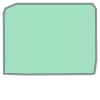

In [21]:
convex_hull = edges.unary_union.convex_hull
convex_hull

#### CRS Projection
You can also look at the projection of the graph. To find out more about projections, check out this section. Additionally, you can also reproject the graph to a different CRS.

In [22]:
edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
merc_edges = edges.to_crs(epsg=3857)
merc_edges.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Shortest Path Analysis

To calculate the shortest path, we first need to find the closest nodes on the network to our starting and ending locations.

In [ ]:
# !pip install ipyleaflet

In [24]:
from ipyleaflet import *

# Plaza Mayor Madrid
center=(40.4155, -3.7043) 
# Puerta del Sol
source_point = (40.416729, -3.703339)  
# Plaza de España
destination_point = (40.423382, -3.712165) 

m = Map(center=center, zoom=14)
m.add_layer(Marker(location=source_point, icon=AwesomeIcon(name='camera', marker_color='red')))
m.add_layer(Marker(location=center, icon=AwesomeIcon(name='graduation-cap')))
m.add_layer(Marker(location=destination_point, icon=AwesomeIcon(name='university',marker_color='green')))
m

Map(center=[40.4155, -3.7043], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

Notice that the way we create maps in ipyleaflet is different from folium. For the latter, the code is as follows:

In [25]:
import folium
m = folium.Map(location=center, zoom_start=15)
folium.Marker(location=source_point,icon=folium.Icon(color='red',icon='camera', prefix='fa')).add_to(m)
folium.Marker(location=center,icon=folium.Icon(color='blue',icon='graduation-cap', prefix='fa')).add_to(m)
folium.Marker(location=destination_point,icon=folium.Icon(color='green',icon='university', prefix='fa')).add_to(m)
m

Let’s revisit our trip across Madrid from the statue in Puerta del Sol to Plaza de España.

To calculate the shortest path, we first need to find the closest nodes on the network to our starting and ending locations.

In [ ]:
# !pip install geopandas

In [26]:
import geopandas

X = [source_point[1], destination_point[1]]
Y = [source_point[0], destination_point[0]]
closest_nodes = ox.distance.nearest_nodes(graph,X,Y)

# Get the rows from the Node GeoDataFrame
closest_rows = nodes.loc[closest_nodes]

# Put the two nodes into a GeoDataFrame
od_nodes = geopandas.GeoDataFrame(closest_rows, geometry='geometry', crs=nodes.crs)
od_nodes

y         x  street_count highway  \
osmid                                                   
48753682    40.416728 -3.703279             5     NaN   
9281776617  40.423180 -3.711909             1     NaN   

                             geometry  
osmid                                  
48753682    POINT (-3.70328 40.41673)  
9281776617  POINT (-3.71191 40.42318)

Let’s find and plot the shortest route now!

In [ ]:
# !pip install networkx[default]

In [27]:
import networkx

shortest_route = networkx.shortest_path(G=graph,source=closest_nodes[0],target=closest_nodes[1], weight='length')
print(shortest_route)

[48753682, 9029849697, 5308255543, 5302264639, 9029849699, 5302261811, 5302264626, 5302264623, 5302457522, 5302457521, 7618346989, 5302457525, 3275558364, 1522690080, 3838019492, 4396614774, 3838019502, 3838019503, 3838019504, 4110080034, 4110080035, 4110080038, 1414829225, 4110080041, 4110068962, 4110080047, 8014642970, 4110080049, 4110080051, 4110080056, 4110080057, 5308158262, 4110049014, 4110049013, 3275558374, 1352957236, 1352957241, 1501171139, 1501200354, 1501171130, 9281776617]


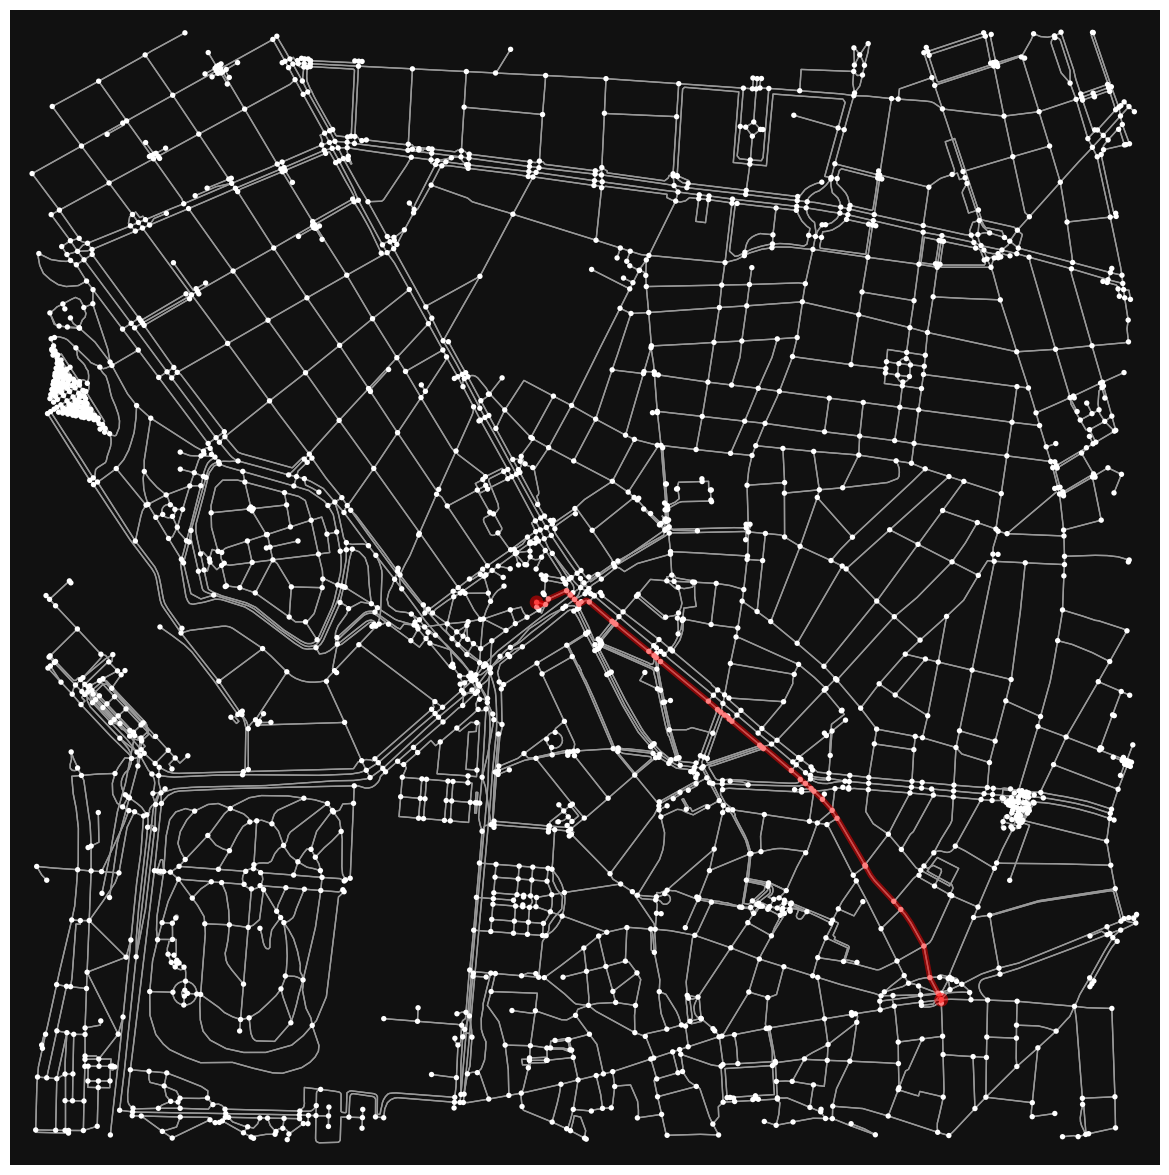

(<Figure size 1500x1500 with 1 Axes>, <AxesSubplot: >)

In [28]:
ox.plot_graph_route(graph,shortest_route,figsize=(15,15))

Let’s make a map that shows the above route, with both starting and ending nodes shown as markers using draw_route implemented as part of our Python package optalgotools.

In [ ]:
# !pip install optalgotools

In [29]:
from optalgotools import routing

routing.draw_route(graph, shortest_route)

#### Retrieve buildings from named place

Just like our graph above, we can also retrieve all the building footprints of a named place.

c:\Users\Alaa\.conda\envs\ox\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



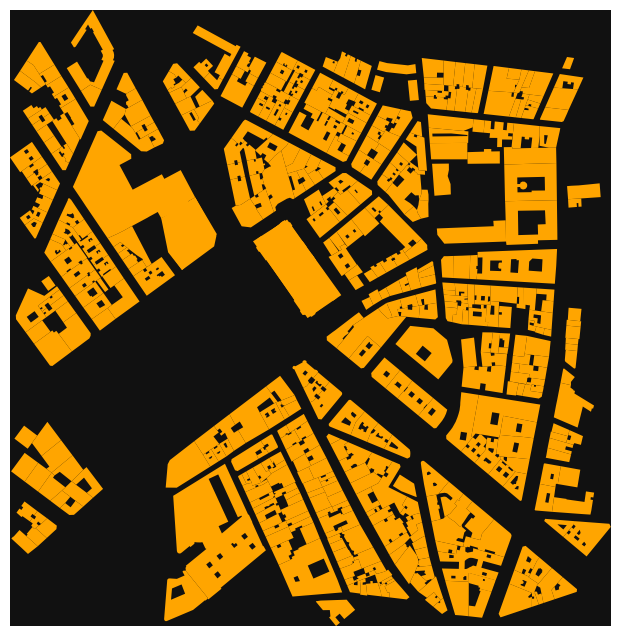

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [31]:
# Retrieve the building footprint, project it to match our previous graph, and plot it.
buildings = ox.geometries.geometries_from_address(place_name, tags={'building':True}, dist=300)
buildings = buildings.to_crs(edges.crs)
ox.plot_footprints(buildings)

Now that we have the building footprints of Madrid, let’s plot that shortest route again.

First, get the nodes from the shortest route, create a geometry from it, and then visualize building footprints, street network, and shortest route all on one plot.


In [ ]:
# !pip install shapely

In [32]:
from shapely.geometry import LineString

# Nodes of our shortest path
route_nodes = nodes.loc[shortest_route]

# Convert the nodes into a line geometry
route_line = LineString(list(route_nodes.geometry.values))

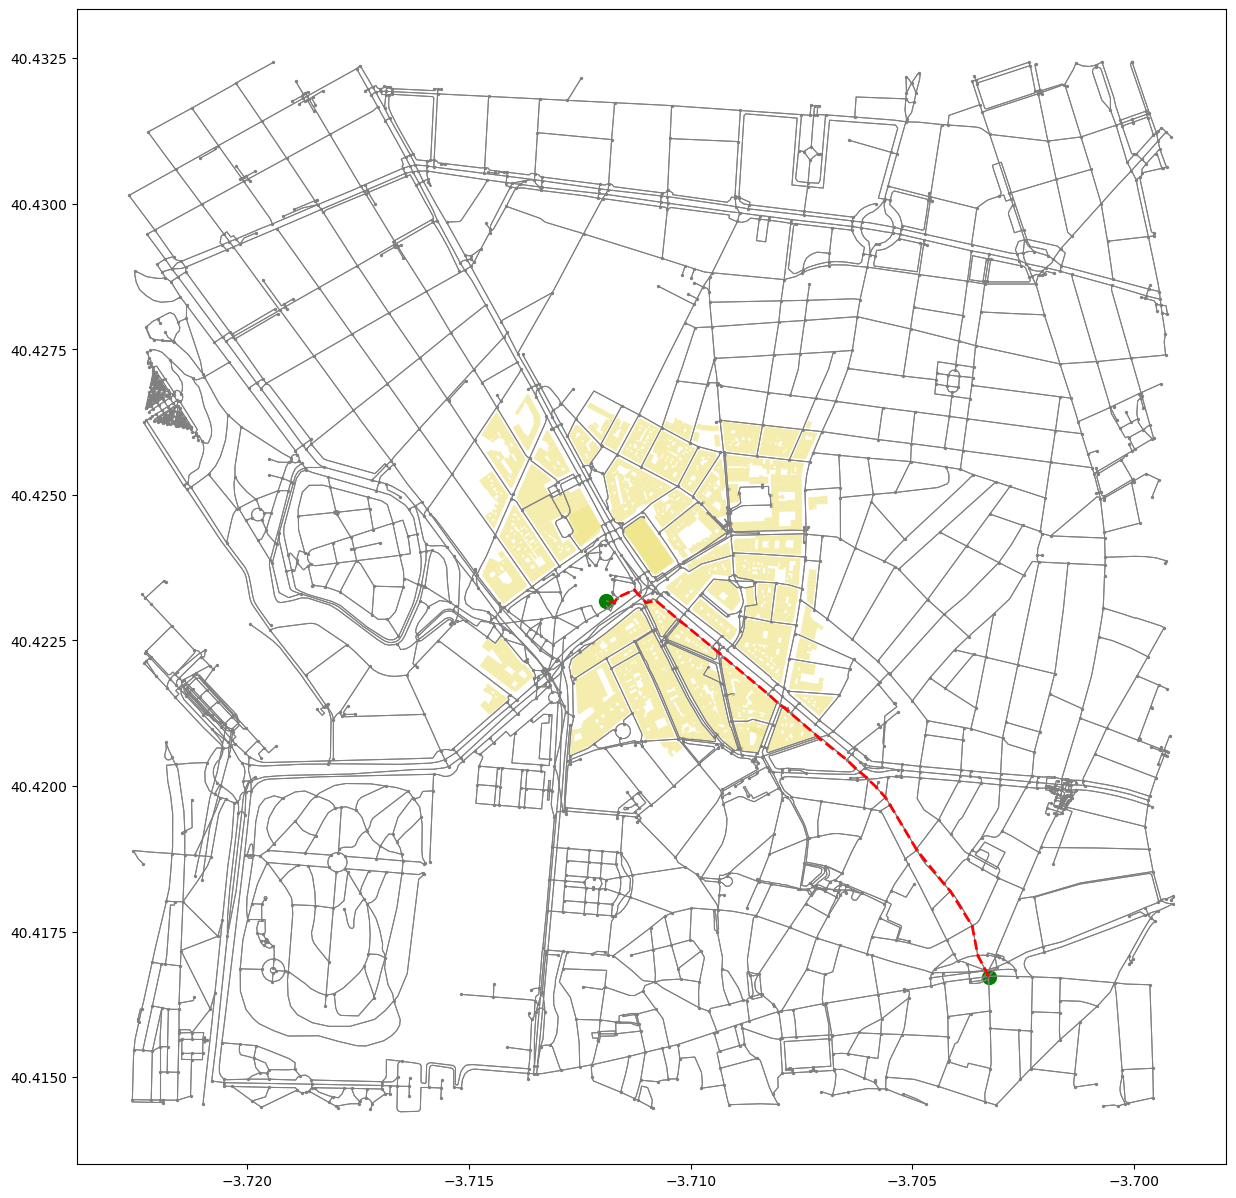

In [33]:
# Create a GeoDataFrame from the line
route_geom = geopandas.GeoDataFrame([[route_line]], geometry='geometry', crs=edges.crs, columns=['geometry'])

# Plot edges and nodes
ax = edges.plot(linewidth=0.75, color='gray', figsize=(15,15))
ax = nodes.plot(ax=ax, markersize=2, color='gray')

# Add building footprints
ax = buildings.plot(ax=ax, facecolor='khaki', alpha=0.7)

# Add the shortest route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Highlight the starting and ending nodes
ax = od_nodes.plot(ax=ax, markersize=100, color='green')

### Fetching data using pyrosm

In [34]:
# !pip install pyrosm

In [35]:
import pyrosm
import matplotlib

# List available places
available_places = pyrosm.data.available
print(available_places.keys())
print(available_places['cities'])

dict_keys(['test_data', 'regions', 'subregions', 'cities'])
['Aachen', 'Aarhus', 'Adelaide', 'Albuquerque', 'Alexandria', 'Amsterdam', 'Antwerpen', 'Arnhem', 'Auckland', 'Augsburg', 'Austin', 'Baghdad', 'Baku', 'Balaton', 'Bamberg', 'Bangkok', 'Barcelona', 'Basel', 'Beijing', 'Beirut', 'Berkeley', 'Berlin', 'Bern', 'Bielefeld', 'Birmingham', 'Bochum', 'Bogota', 'Bombay', 'Bonn', 'Bordeaux', 'Boulder', 'BrandenburgHavel', 'Braunschweig', 'Bremen', 'Bremerhaven', 'Brisbane', 'Bristol', 'Brno', 'Bruegge', 'Bruessel', 'Budapest', 'BuenosAires', 'Cairo', 'Calgary', 'Cambridge', 'CambridgeMa', 'Canberra', 'CapeTown', 'Chemnitz', 'Chicago', 'ClermontFerrand', 'Colmar', 'Copenhagen', 'Cork', 'Corsica', 'Corvallis', 'Cottbus', 'Cracow', 'CraterLake', 'Curitiba', 'Cusco', 'Dallas', 'Darmstadt', 'Davis', 'DenHaag', 'Denver', 'Dessau', 'Dortmund', 'Dresden', 'Dublin', 'Duesseldorf', 'Duisburg', 'Edinburgh', 'Eindhoven', 'Emden', 'Erfurt', 'Erlangen', 'Eugene', 'Flensburg', 'FortCollins', 'Frankfur

In [36]:
place_name = 'Cairo'
file_path = pyrosm.get_data(place_name)
print('Data downloaded to:', file_path)

Data downloaded to: C:\Users\Alaa\AppData\Local\Temp\pyrosm\Cairo.osm.pbf


In [37]:
# Initialises the OSM object that parses the generated .osm.pbf files
osm = pyrosm.OSM(file_path)
print('osm type:', type(osm))

osm type: <class 'pyrosm.pyrosm.OSM'>


### Getting data from open data repositories

This is an example of how to read data from URL. The Bike Share Toronto Ridership data contains anonymized trip data, including: Trip start day and time, Trip end day and time, Trip duration, Trip start station, Trip end station, User type. This dataset is from Toronto Parking Authority, published on https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/.

In [39]:
import requests
import json
import matplotlib.pyplot as plt
import folium

# URL of the Bike Share dataset file
url = 'https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information'

# Fetch the contents of the URL
response = requests.get(url)

# Extract the JSON content from the response
json_data = response.json()

# Extract the station informations
stations = json_data.get("data", {}).get("stations", [])
extracted_data = []
for station in stations:
  extracted_data.append({"station_id": station.get("station_id"), "name": station.get("name"), "lat": station.get("lat"), "lon": station.get("lon"), "address": station.get("address"), "capacity": station.get("capacity")})

# Create a folium map centered around Toronto
toronto_map = folium.Map(location=[43.651070, -79.347015], zoom_start=12)

# Add markers for each bike share station
for station in extracted_data:
    lat = station["lat"]
    lon = station["lon"]
    id = station["station_id"]
    name = station["name"]
    capacity = station["capacity"]

    # Create a marker and add it to the map
    folium.Marker(
        location=[lat, lon],
        popup=f"Id: {id}<br>Name: {name}<br>Capacity: {capacity}",
        icon=folium.Icon(color="blue", icon="info-sign"),
    ).add_to(toronto_map)

# Display the map
toronto_map

### Download the Microsoft building footprints using leafmap

In [ ]:
# !pip install leafmap

In [5]:
import leafmap

country = "Canada"

# Specify the number of files to download. Set to None to download all files.
head = 2

leafmap.download_ms_buildings(
    country, 
    out_dir="buildings", 
    merge_output=f"{country}_ms.shp", 
    head=head
    )

Found 2055 links for Canada
Reading 1 of 2: buildings\2331210.geojson
Reading 2 of 2: buildings\2333022.geojson
Merging GeoDataFrames ...
Saving merged file to Canada_ms.shp ...
Saved merged file to Canada_ms.shp


['buildings\\2331210.geojson', 'buildings\\2333022.geojson']

### Display the building footprints

In [6]:
m = leafmap.Map()
m.add_basemap("SATELLITE")
m.add_vector(f"{country}_ms.shp", layer_name="MS Buildings")
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

# Geospatial Datasets

This section includes a non-exhaustive list of datasets that may be of interest to you. Some sources are open source, while others offer "freemium" or paid options.

#### 1. Available open datasets
* [Geofabrik](https://download.geofabrik.de/index.html)
* [Factory POI](http://www.poi-factory.com/)
* [Global Rural-Urban Mapping Project (GRUMP)](https://sedac.ciesin.columbia.edu/data/set/grump-v1-settlement-points)
* [GeoNames Data](https://www.geonames.org/export/)
* [City of Toronto](https://www.toronto.ca/city-government/data-research-maps/open-data/)
* [ArcGIS Hub](https://www.esri.com/en-us/arcgis/products/arcgis-hub/overview)
* [GeoHub City of Brampton](https://geohub.brampton.ca/pages/data)
* [City of Markham](https://data-markham.opendata.arcgis.com/)
* [New York City](https://opendata.cityofnewyork.us/)
* [BBBike](https://extract.bbbike.org/)
* [Mapzen](https://github.com/tilezen/joerd/tree/master/docs)
* [openterrain list](https://github.com/openterrain/openterrain/wiki/Terrain-Data)
* [terrain party](https://terrain.party/)
* [OpenMapTiles](https://openmaptiles.org/)
* [UofT MDL](https://mdl.library.utoronto.ca/)
* [GADM maps and data](https://gadm.org/index.html)
* [Elevation data](https://www.opentopodata.org/)
* [SRTM C-BAND DATA PRODUCTS](https://www2.jpl.nasa.gov/srtm/cbanddataproducts.html)
* [CGIAR-CSI SRTM raster data](https://srtm.csi.cgiar.org/srtmdata/)
* [Wikimapia](https://wikimapia.org/)
* [geodatasets](https://geodatasets.readthedocs.io/en/latest/)

---

#### 2. Commercially available datasets
* [Planet.osm](https://planet.openstreetmap.org/)
* [MapTiler](https://www.maptiler.com/)
* [Factual Global Places](https://www.factual.com/data-set/global-places/)
* [TravelTime API](https://docs.traveltime.com/api/overview/introduction)
* [Precisely](https://www.precisely.com/)
* [World Cities Database](https://www.worldcitiesdatabase.com )
* [SafeGraph](https://www.safegraph.com/)
* [Google Maps Platform](https://cloud.google.com/maps-platform/)
* [Here Maps for Developers](https://developer.here.com/products/here-sdk)
* [Ratio City](https://www.ratio.city/)
* [100 feet](https://www.beans.ai/index)
* [MPAC Residential Property Assessments](https://www.mpac.ca/)
* [Geodata Tufts](https://geodata.tufts.edu/)

---

#### 3. Elevation Data
* [Open Elevation API](https://open-elevation.com/)
* [Open Topo Data API](https://www.opentopodata.org/#public-api)
* [National Map API](https://nationalmap.gov/)
* [Google Maps API](https://developers.google.com/maps/documentation/elevation/overview)

---

#### 4. Traffic Datasets
* [traffic per edge](https://github.com/Project-OSRM/osrm-backend/wiki/Traffic)
* [Open Traffic](https://github.com/opentraffic)
* [Google Routes](https://cloud.google.com/maps-platform/routes)

---
#### 5. Parking Tickets Datasets
* [City of Toronto Parking Tickets](https://ckan0.cf.opendata.inter.prod-toronto.ca/tr/dataset/parking-tickets)
* [Toronto Parking Tickets Visualziation](https://github.com/ian-whitestone/toronto-parking-tickets)
* [Others](https://data.world/datasets/parking-ticket)

---
#### 6. Public Transport Networks Datasets
* [Google Transit APIs](https://developers.google.com/transit)

---
#### 7. Planned events, road work, and other temporary changes to the road network and bridge, tunnel and ferry events
* [one.network](https://us.one.network/)
* [ROAD dataset](https://github.com/gurkirt/road-dataset)
* [Road Point Events](https://open.canada.ca/data/en/dataset/35e1d8d3-cb2f-434d-a20c-584ea5037fa0)

---
#### 8. Traffic Crashes Datasets
* [A Countrywide Traffic Accident Dataset (2016 - 2020)](https://www.kaggle.com/sobhanmoosavi/us-accidents)
* [traffic per edge](https://github.com/Project-OSRM/osrm-backend/wiki/Traffic) 
* [Open traffic](https://github.com/opentraffic)
* [AV Documented Incidents](https://www.austintexas.gov/page/autonomous-vehicles)
* [Others](https://data.world/datasets/crash)

---
#### 9. Emission Datasets
* [Open Climate Data](https://openclimatedata.net/)
* [Ontario Air Quality Data Sets](http://www.airqualityontario.com/science/data_sets.php)
* [Others](https://data.world/datasets/co2)

---
#### 10. Environmental Datasets
* [Canadian Open Geospatial Data](https://canadiangis.com/data.php)
* [Government of Canada Open Data Portal](https://open.canada.ca/data/en/dataset)

---
#### 11. Mobility-aware urban design, active transportation modeling and access analysis for amenities and public transport
* [Urbano](https://www.urbano.io/)


---
#### 12. Accessibility
* [Wheelmap](https://wheelmap.org/)
* [accessibility.cloud](https://www.accessibility.cloud/)

---
#### 13. Crime map
* [Crime map](https://www.crimemapping.com/map/agency/91)
* [Others](https://data.world/datasets/crime)

---
#### 14. Open Source Projects
* [GIScience](https://github.com/GIScience)